In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def universe_partition_fix_end(data, U1, U2):
    std_val = data.std(axis=0)
    len_val = np.round(std_val / 10)
    u_max, u_min = U2, U1 # bound of universe discourse
    u_b = np.arange(u_min, u_max, step=float(len_val)) # cutting points
    u_discourse = u_b
    return u_discourse

def universe_partition(data, d1=10, d2=10):
    x_max, x_min = data.max(axis=0), data.min(axis=0)    
    std_val = data.std(axis=0)
    len_val = np.round(std_val / 10)
    u_max, u_min = int(x_max+d2), int(x_min-d1) # bound of universe discourse
    u_b = np.arange(u_min, u_max, step=float(len_val)) # cutting points
    u_discourse = u_b
    return u_discourse

def set_fuzzy_numbers(u_discourse_raw):
    u_s = u_discourse_raw[:-1]
    u_e = u_discourse_raw[1:]
    u_discourse = zip(u_s, u_e)
    fuzzy_numbers = list()
    for i, u_i in enumerate(u_discourse):
        fuzzy_numbers.append(np.array([u_i[0], u_i[1]]))
    return fuzzy_numbers

In [3]:
def membership_assignment(value_time_series, fuzzy_numbers):
    membership_list = np.digitize(value_time_series, fuzzy_numbers)-1
    membership_list[membership_list<0] = 0
    max_index = len(fuzzy_numbers) - 2
    membership_list[membership_list>max_index] = max_index
    return membership_list.tolist()

def get_membership(value, fuzzy_numbers):
    membership_index = np.digitize([value], fuzzy_numbers)[0]-1
    if membership_index < 0:
        membership_index = 0
    max_index = len(fuzzy_numbers) - 2
    if membership_index > max_index:
        membership_index = max_index
    return membership_index

In [4]:
def FLR(membership_time_series): # transition between consecutive observations
    transitions = list()
    for j, Aj in enumerate(membership_time_series):
        if j!=0:
            Ai = membership_time_series[j-1]
            transitions.append((Ai, Aj))
    return transitions

def FLR_weight(transitions, time_series): # compute jump frequency by FLR
    jumps = map(lambda x: x[1]-x[0], transitions) # compute jumps by transitions 
    jump_time_series = zip(jumps, time_series) # assign timestamp for each jump beta^t_p,p+k
    jump_counts = defaultdict(list) 
    for key, value in jump_time_series:
        jump_counts[key].append(value) # count jump by its timestamps
    jump_counts = {key: sum(value) for key, value in jump_counts.items()} # sum up total time for each jump
    total_count = float(sum(jump_counts.values()))
    for key, value in jump_counts.iteritems(): 
        jump_counts[key] = value / total_count # normalize jumps as weights
    return jump_counts

def FRG_weight(transitions, time_series): 
    transition_time_series = zip(transitions, time_series)
    transition_groups = map(lambda x: (x[0][0], (x[0][1], x[1])), transition_time_series) 
    transition_weights = defaultdict(list)
    for key, value in transition_groups:
        transition_weights[key].append(value) # group transitions by initial state A_i
    transition_weights = {key: dict(value) for key, value in transition_weights.items()}
    for key, value in transition_weights.iteritems():
        total_weight = float(sum(value.values()))
        value = {k: (v/total_weight) for k, v in value.items()} # normalize weight inside each group
        transition_weights[key] = value
    return transition_weights

In [5]:
# forecasting by fuzzy numbers
def fuzzy_add(A, B): # Proposition #1 (1)
    return A + B # A and B are numpy array type

def fuzzy_scale(c, A): # Proposition #1 (2)
    cA = c*A # A is numpy array type
    if c>=0:
        return cA
    else:
        return cA[::-1]

def forecast_jump(i, s, A_list):
    jumps = s.keys() # possible jumps
    m = len(A_list) # number of fuzzy numbers in model
    sA_list = list()
    sk_list = list()
    Aip_list = list()
    sA = np.array([0.0]*len(A_list[0]))
    for k in jumps:
        ip = k+i
        if (ip>=0 and ip<m): # check if index is within range
            sk_list.append(s[k])
            Aip_list.append(A_list[ip])
    sk_list = np.array(sk_list) / sum(sk_list) # normalize locally
    for i in range(sk_list.size):
        sA_list.append(fuzzy_scale(sk_list[i], Aip_list[i]))
    if len(sA_list)>0:
        for sa in sA_list:
            sA = fuzzy_add(sA, sa)
    return sA
    
def forecast_transition(i, w, A_list):
    wA = np.array([0.0]*len(A_list[0])) # default FLG relation
    if i in w.keys():
        for kj, v in w[i].iteritems():
            wA = fuzzy_add(wA, fuzzy_scale(v, A_list[kj]))
    return wA

def forecast_price(As, Aw, gamma=0.1):
    if gamma<0 or gamma>1:
        raise ValueError("gamma should be between 0.0 and 1.0 (inclusive on both ends)")     
    wAi = fuzzy_scale(1-gamma, Aw)
    if (np.sum(wAi) == 0): # no FLR observed in history
        sAi = As
    else:
        sAi = fuzzy_scale(gamma, As)
    Ai_pred = fuzzy_add(sAi, wAi)
    return np.mean(Ai_pred)

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100 # beware of zero division

In [7]:
start_time = time()
datafile = '../data/DAX30.csv'
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv(datafile, header=0, parse_dates=['Date'], date_parser=dateparse)

split_date = pd.datetime.strptime('2014-12-31', '%Y-%m-%d')
train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]
first_date = train_data['Date'][0] - pd.DateOffset(days=1)

option = 'Open'
gamma = 1.0
D1 = 953
D2 = 812
# U1 = 6600
# U2 = 12000
train_data.describe()

,Open,High,Low,Close,Volume
count,503.000000,503.000000,503.000000,503.000000,503.000000
mean,79.947117,80.301213,79.482584,79.886322,17844.528827
std,6.418302,6.432289,6.392479,6.391053,24528.858747
min,67.610000,68.070000,67.010000,67.250000,161.000000
25%,74.000000,74.325000,73.590000,74.045000,3520.000000
50%,81.710000,82.230000,81.210000,81.740000,8702.000000
75%,85.600000,86.055000,85.115000,85.565000,23570.500000
max,90.000000,90.000000,89.400000,89.760000,183470.000000


In [8]:
test_data.describe()

,Open,High,Low,Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000
mean,97.268730,97.920159,96.501429,97.203095,7840.706349
std,6.244972,6.233347,6.237393,6.262898,9261.485763
min,83.500000,84.070000,82.500000,83.260000,325.000000
25%,93.265000,93.482500,91.967500,92.745000,2465.250000
50%,97.435000,97.990000,96.560000,97.420000,5041.500000
75%,101.975000,102.382500,100.952500,101.845000,9528.000000
max,110.100000,110.230000,109.810000,110.080000,85270.000000


In [9]:
# fit training data
train_features = train_data[option].tolist()[:-1]
train_prices = train_data[option].tolist()[1:]
fit_prices = list()
u_discourse = universe_partition(train_data[option], d1=D1, d2=D2)
# u_discourse = universe_partition_fix_end(train_data[option], U1, U2)
A_list = set_fuzzy_numbers(u_discourse)
train_data_membership_series = membership_assignment(train_data[option], fuzzy_numbers=u_discourse)
transition_FLR = FLR(train_data_membership_series)
train_data_days = train_data['Date'].apply(lambda x: x-first_date).dt.days.tolist() # convert Timedelta to numeric days
jump_weights = FLR_weight(transition_FLR, train_data_days[:len(transition_FLR)])
transition_weights = FRG_weight(transition_FLR, train_data_days[:len(transition_FLR)])
for price in train_features:
    index = get_membership(price, u_discourse)
    next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=gamma)
    fit_prices.append(next_price)
print np.sqrt(mean_squared_error(train_prices, fit_prices))

0.908174174867


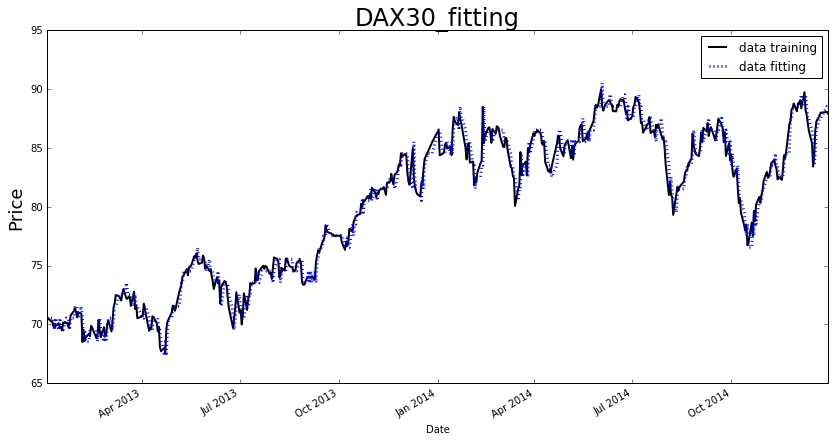

In [10]:
df_train = pd.DataFrame(train_data[1:]['Date'])
df_train['data training'] = pd.Series(train_prices).values
df_train['data fitting'] = pd.Series(fit_prices).values
df_train.index = df_train['Date']
plt.figure(figsize=(14,7))
df_train['data training'].plot(style='k-', linewidth=2, label='data training')
df_train['data fitting'].plot(style='b:', linewidth=3, label='data fitting')
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.title("DAX30_fitting", fontsize=24)

In [11]:
# forecasting using test data
pred_prices = list()
actual_prices = test_data[option].tolist()[1:]
indices = test_data.index
for i in range(len(indices)-1):
    stm = time()
    #id = indices[i]
    prev = test_data.iloc[i]
    train_data.append(prev)
#     print("Update data: %s seconds" % str(time() - stm))
    stm = time()
    u_discourse = universe_partition(train_data[option], d1=D1, d2=D2)
#     u_discourse = universe_partition_fix_end(train_data[option], U1, U2)
#     print("Partition discourse: %s seconds" % str(time() - stm))
    stm = time()
    A_list = set_fuzzy_numbers(u_discourse)
#     print("Create fuzzy number: %s seconds" % str(time() - stm))
    stm = time()
    train_data_membership_series = membership_assignment(train_data[option], fuzzy_numbers=u_discourse)
#     train_data_ms = [ms+1 for ms in train_data_membership_series]
#     print("Update fuzzy membership: %s seconds" % str(time() - stm))
    stm = time()
    transition_FLR = FLR(train_data_membership_series)
#     print("Update FLR: %s seconds" % str(time() - stm))
    stm = time()
    train_data_days = train_data['Date'].apply(lambda x: x-first_date).dt.days.tolist() # convert Timedelta to numeric days
    jump_weights = FLR_weight(transition_FLR, train_data_days[:len(transition_FLR)])
#     print("Update jump weights: %s seconds" % str(time() - stm))
    stm = time()
    transition_weights = FRG_weight(transition_FLR, train_data_days[:len(transition_FLR)])
#     print("Update transition weights: %s seconds" % str(time() - stm))
    stm = time()
    # forecasting current test data
    price = prev[option]
    index = get_membership(price, u_discourse)
#     print("Assign membership for test case: %s seconds" % str(time() - stm))
    stm = time()
    next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=gamma)
#     print("Forecast next price: %s seconds" % str(time() - stm))
    stm = time()
    pred_prices.append(next_price)
    
print "MAD = "+str(mean_absolute_error(actual_prices, pred_prices))
print "RMSE = "+str(np.sqrt(mean_squared_error(actual_prices, pred_prices)))
print "MAPE = "+str(mean_absolute_percentage_error(actual_prices, pred_prices))
print "Time cost: "+str(time()-start_time)+" seconds" 

MAD = 1.10297528588
RMSE = 1.39182081783
MAPE = 1.14129743003
Time cost: 7.80475997925 seconds


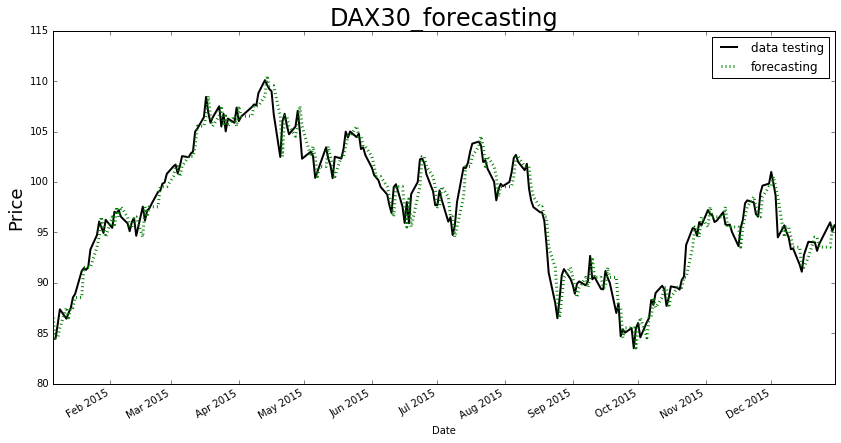

In [12]:
df_test = pd.DataFrame(test_data.iloc[1:]['Date'])
df_test['data testing'] = pd.Series(actual_prices).values
df_test['forecasting'] = pd.Series(pred_prices).values
df_test.index = df_test['Date']
plt.figure(figsize=(14,7))
df_test['data testing'].plot(style='k-', linewidth=2, label='data testing')
df_test['forecasting'].plot(style='g:', linewidth=3, label='forecasting')
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.title("DAX30_forecasting", fontsize=24)

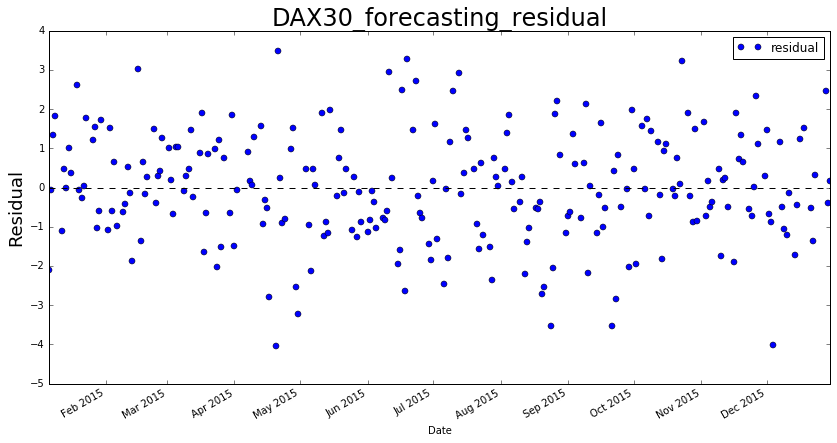

In [13]:
plt.figure(figsize=(14,7))
df_test["residual"] = df_test["data testing"] - df_test["forecasting"]
df_test["residual"].plot(style='bo', linewidth=3, label='residual')
plt.ylabel('Residual', fontsize=18)
plt.axhline(y=0.0, color='k', linestyle='--')
plt.legend(loc='best')
plt.title("DAX30_forecasting_residual", fontsize=24)